# Bootstrap Examples

_This setup code is required to run in an IPython notebook_

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn

In [2]:
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90

## Sharpe Ratio

The Sharpe Ratio is an important measure of return per unit of risk.  The example shows how to estimate the variance of the Sharpe Ratio and how to construct confidence intervals for the Sharpe Ratio using a long series of U.S. equity data.

In [3]:
import numpy as np
import pandas as pd

import arch.data.frenchdata

ff = arch.data.frenchdata.load()

The data set contains the Fama-French factors, including the excess market return.

In [4]:
excess_market = ff.iloc[:, 0]
print(ff.describe())

            Mkt-RF          SMB          HML           RF
count  1109.000000  1109.000000  1109.000000  1109.000000
mean      0.659946     0.206555     0.368864     0.274220
std       5.327524     3.191132     3.482352     0.253377
min     -29.130000   -16.870000   -13.280000    -0.060000
25%      -1.970000    -1.560000    -1.320000     0.030000
50%       1.020000     0.070000     0.140000     0.230000
75%       3.610000     1.730000     1.740000     0.430000
max      38.850000    36.700000    35.460000     1.350000


The next step is to construct a function that computes the Sharpe Ratio.  This function also return the annualized mean and annualized standard deviation which will allow the covariance matrix of these parameters to be estimated using the bootstrap.

In [5]:
def sharpe_ratio(x):
    mu, sigma = 12 * x.mean(), np.sqrt(12 * x.var())
    values = np.array([mu, sigma, mu / sigma]).squeeze()
    index = ['mu', 'sigma', 'SR']
    return pd.Series(values, index=index)

The function can be called directly on the data to show full sample estimates.

In [6]:
params = sharpe_ratio(excess_market)
params

mu        7.919351
sigma    18.455084
SR        0.429115
dtype: float64

### _Warning_

_The bootstrap chosen must be appropriate for the data.  Squared returns are serially correlated, and so a time-series bootstrap is required._

Bootstraps are initialized with any bootstrap specific parameters and the data to be used in the bootstrap.  Here the `12` is the average window length in the Stationary Bootstrap, and the next input is the data to be bootstrapped.

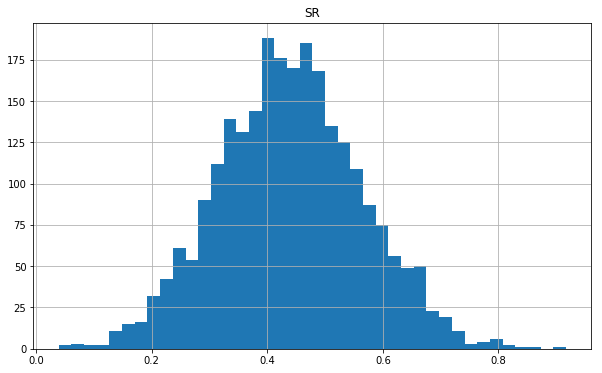

In [7]:
from arch.bootstrap import StationaryBootstrap

bs = StationaryBootstrap(12, excess_market)
results = bs.apply(sharpe_ratio, 2500)
SR = pd.DataFrame(results[:, -1:], columns=['SR'])
fig = SR.hist(bins=40)

In [8]:
cov = bs.cov(sharpe_ratio, 1000)
cov = pd.DataFrame(cov, index=params.index, columns=params.index)
print(cov)
se = pd.Series(np.sqrt(np.diag(cov)), index=params.index)
se.name = 'Std Errors'
print('\n')
print(se)

             mu     sigma        SR
mu     4.030023 -0.619655  0.233911
sigma -0.619655  3.224082 -0.108527
SR     0.233911 -0.108527  0.015437


mu       2.007492
sigma    1.795573
SR       0.124246
Name: Std Errors, dtype: float64


In [9]:
ci = bs.conf_int(sharpe_ratio, 1000, method='basic')
ci = pd.DataFrame(ci, index=['Lower', 'Upper'], columns=params.index)
print(ci)

              mu      sigma        SR
Lower   3.979704  14.376525  0.175532
Upper  11.742457  21.566741  0.635923


Alternative confidence intervals can be computed using a variety of methods.  Setting `reuse=True` allows the previous bootstrap results to be used when constructing confidence intervals using alternative methods.

In [10]:
ci = bs.conf_int(sharpe_ratio, 1000, method='percentile', reuse=True)
ci = pd.DataFrame(ci, index=['Lower', 'Upper'], columns=params.index)
print(ci)

              mu      sigma        SR
Lower   4.096244  15.343426  0.222307
Upper  11.858997  22.533642  0.682698


## Probit (Statsmodels)

The second example makes use of a Probit model from Statsmodels.  The demo data is university admissions data which contains a binary variable for being admitted, GRE score, GPA score and quartile rank. This data is downloaded from the internet and imported using pandas.

In [11]:
import arch.data.binary

binary = arch.data.binary.load()
binary = binary.dropna()
print(binary.describe())

            admit         gre         gpa       rank
count  400.000000  400.000000  400.000000  400.00000
mean     0.317500  587.700000    3.389900    2.48500
std      0.466087  115.516536    0.380567    0.94446
min      0.000000  220.000000    2.260000    1.00000
25%      0.000000  520.000000    3.130000    2.00000
50%      0.000000  580.000000    3.395000    2.00000
75%      1.000000  660.000000    3.670000    3.00000
max      1.000000  800.000000    4.000000    4.00000


### Fitting the model directly

The first steps are to build the regressor and the dependent variable arrays.  Then, using these arrays, the model can be estimated by calling `fit`

In [12]:
import statsmodels.api as sm

endog = binary[['admit']]
exog = binary[['gre', 'gpa']]
const = pd.Series(np.ones(exog.shape[0]), index=endog.index)
const.name = 'Const'
exog = pd.DataFrame([const, exog.gre, exog.gpa]).T

# Estimate the model
mod = sm.Probit(endog, exog)
fit = mod.fit(disp=0)
params = fit.params
print(params)

Const   -3.003536
gre      0.001643
gpa      0.454575
dtype: float64


### The wrapper function

Most models in Statsmodels are implemented as classes, require an explicit call to `fit` and return a class containing parameter estimates and other quantities.  These classes cannot be directly used with the bootstrap methods.  However, a simple wrapper can be written that takes the data as the only inputs and returns parameters estimated using a Statsmodel model.

In [13]:
def probit_wrap(endog, exog):
    return sm.Probit(endog, exog).fit(disp=0).params

A call to this function should return the same parameter values.

In [14]:
probit_wrap(endog, exog)

Const   -3.003536
gre      0.001643
gpa      0.454575
dtype: float64

The wrapper can be directly used to estimate the parameter covariance or to construct confidence intervals.

In [15]:
from arch.bootstrap import IIDBootstrap

bs = IIDBootstrap(endog=endog, exog=exog)
cov = bs.cov(probit_wrap, 1000)
cov = pd.DataFrame(cov, index=exog.columns, columns=exog.columns)
print(cov)

          Const           gre       gpa
Const  0.435172 -8.601967e-05 -0.110662
gre   -0.000086  4.124129e-07 -0.000047
gpa   -0.110662 -4.692308e-05  0.040495


In [16]:
se = pd.Series(np.sqrt(np.diag(cov)), index=exog.columns)
print(se)
print('T-stats')
print(params / se)

Const    0.659675
gre      0.000642
gpa      0.201234
dtype: float64
T-stats
Const   -4.553051
gre      2.557696
gpa      2.258936
dtype: float64


In [17]:
ci = bs.conf_int(probit_wrap, 1000, method='basic')
ci = pd.DataFrame(ci, index=['Lower', 'Upper'], columns=exog.columns)
print(ci)

          Const       gre       gpa
Lower -4.183013  0.000413  0.064824
Upper -1.671674  0.002832  0.840327


### Speeding things up

Starting values can be provided to `fit` which can save time finding starting values.  Since the bootstrap parameter estimates should be close to the original sample estimates, the full sample estimated parameters are reasonable starting values.  These can be passed using the `extra_kwargs` dictionary to a modified wrapper that will accept a keyword argument containing starting values.

In [18]:
def probit_wrap_start_params(endog, exog, start_params=None):
    return sm.Probit(endog, exog).fit(start_params=start_params, disp=0).params

In [19]:
bs.reset()  # Reset to original state for comparability
cov = bs.cov(
    probit_wrap_start_params,
    1000,
    extra_kwargs={'start_params': params.values})
cov = pd.DataFrame(cov, index=exog.columns, columns=exog.columns)
print(cov)

          Const           gre       gpa
Const  0.435172 -8.601967e-05 -0.110662
gre   -0.000086  4.124129e-07 -0.000047
gpa   -0.110662 -4.692308e-05  0.040495


## Bootstrapping Uneven Length Samples
Independent samples of uneven length are common in experiment settings, e.g., A/B testing of a website.  The `IIDBootstrap` allows for arbitrary dependence within an observation index and so cannot be naturally applied to these data sets. The `IndependentSamplesBootstrap` allows datasets with variables of different lengths to be sampled by exploiting the independence of the values to separately bootstrap each component. Below is an example showing how a confidence interval can be constructed for the difference in means of two groups. 

In [20]:
from arch.bootstrap import IndependentSamplesBootstrap


def mean_diff(x, y):
    return x.mean() - y.mean()


rs = np.random.RandomState(0)
treatment = 0.2 + rs.standard_normal(200)
control = rs.standard_normal(800)

bs = IndependentSamplesBootstrap(treatment, control, random_state=rs)
print(bs.conf_int(mean_diff, method='studentized'))

[[0.1991302 ]
 [0.51317728]]
